In [2]:
#import all needed libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm

In [3]:
# Define the new working directory path
new_working_directory = r'C:\Users\Victor\Documents\GitHub\sports-data'

# Change the current working directory
os.chdir(new_working_directory)

# Define the new working directory path
#new_working_directory = r'/Users/nicol1/Documents/GitHub/sports-data'

# Change the current working directory
#os.chdir(new_working_directory)

In [6]:
new_working_directory = '/Users/nicol1/Documents/GitHub/sports-data'

# Change the current working directory
os.chdir(new_working_directory)

In [7]:
# Define the path 
data_folder = 'data/'

# Load the CSV files to df
df = pd.read_csv(data_folder + 'cleaned_df.csv')

In [8]:
# Take a look to the actual DataFrame
df.head()

,name,country,height,foot,position,highest_market_value,current_club_domestic_competition_id,number_games_played,total_minutes,average_minutes,...,red_cards_avg,goals,avg_goals_per_game,assists,age,year,avg_games_per_year,avg_goals_per_year,avg_assists_per_year,fairplay_index
0,Markus Henriksen,Norway,187.0,right,Defender,5000000.0,GB1,165,12199,73.933333,...,0.006061,33,0.200000,22,45.0,6,27.500000,5.500000,3.666667,0.036364
1,Razvan Rat,Romania,179.0,left,Defender,6500000.0,ES1,97,7690,79.278351,...,0.010309,3,0.030928,13,43.0,5,19.400000,0.600000,2.600000,0.072165
2,Darijo Srna,Croatia,182.0,right,Defender,17500000.0,IT1,227,19598,86.334802,...,0.008811,22,0.096916,68,45.0,8,28.375000,2.750000,8.500000,0.095448
3,Fernandinho,Brazil,179.0,right,Midfield,32000000.0,GB1,399,30325,76.002506,...,0.007519,29,0.072682,41,42.0,11,36.272727,2.636364,3.727273,0.091061
4,Henrikh Mkhitaryan,Armenia,177.0,both,Midfield,37000000.0,IT1,485,35878,73.975258,...,0.000000,128,0.263918,119,43.0,13,37.307692,9.846154,9.153846,0.040550


## Introduction

Every time the football transfer windows open, there's a frenzy of rumours and huge sums of money changing hands for players. This trend seems to get worse every year. By 2024, top players such as Kylian Mbappe, Erling Haaland and Jude Bellingham will be valued at a whopping €180 million each.

In Europe's big five leagues - the Premier League, Serie A, La Liga, Ligue 1 and the Bundesliga - we see players with high market values. But how do we determine a footballer's value? What factors influence it? Are players with higher values necessarily better performers? And how do these factors differ for different positions?

In this analysis, we'll look at the factors that influence a player's market value for each position. We'll also train different models and see which one performs best for each position. We'll develop an app that allows users to enter a player's characteristics and, depending on their position, the app will use the appropriate model to estimate their market value. This tool should provide users with valuable insights into player valuation.

## Function definition for plots

These functions are used to assist in the visualisation and analysis of the data set:

- **Correlation Matrix**: This function creates a heatmap illustrating the correlation matrix derived from the numerical data within the DataFrame. The user can specify the position of the players if required.

- **Histograms and scatterplots with regression lines**: Plot histograms and scatterplots with regression lines for selected variables. Users have the flexibility to specify the target variable for regression plots and the order of the polynomial for regression lines.

In [9]:
# Function to plot correlation matrix
def plot_correlation_matrix(data, title, position=None):
    if position:
        data = data[data['position'] == position]
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
    plt.title(title)
    plt.show()
    
# Function to plot histograms and scatter plots with regression lines for a list of variables
# Each variable will have two plots: histogram and scatter with regression
def plot_variable_distributions_with_regression(data, variables, target='highest_market_value', poly_order=1):
    num_variables = len(variables)
    num_plots = num_variables * 2  
    num_rows = num_plots // 2 if num_plots % 2 == 0 else (num_plots // 2) + 1 

    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, num_rows * 6))
    axes = axes.ravel()  

    for i, var in enumerate(variables):
        # Plot histogram - left column
        sns.histplot(data[var], kde=True, ax=axes[i*2], color='skyblue')
        axes[i*2].set_title(f'Histogram of {var}')

        # Plot scatter plot with regression line - right column
        if (i*2 + 1) < len(axes):
            sns.regplot(x=var, y=target, data=data, ax=axes[i*2 + 1], color='salmon', order=poly_order, line_kws={'color':'red'})
            axes[i*2 + 1].set_title(f'{var} vs {target} with Regression Line')

    # Remove unused subplots
    for j in range(num_variables * 2, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Function definition for training and evaluating different Models

The purpose of this function is to simplify the process of training and evaluating various regression models used to predict the market value of players in a given position.

It take an input of three main inputs: 
- a **DataFrame** containing the dataset
- the **position of the players** 
- list of **features** used to train the models. 

After processing, the function provides a dictionary that consolidates the evaluation results of each model. These results include metrics such as the R^2 score, along with the mean and standard deviation of the cross-validated R^2. It also includes intercept, p-value and f-value data where relevant.

The function also retains the trained models and imputers for subsequent predictions.

Models included in our analysis include

- **LinearRegression**
- **RidgeRegression**
- **LassoRegression**
- **PolynomialRegression**
- **RandomForestRegressor**
- **GradientBoostingRegressor**
- **SVR**

In [10]:
def train_and_evaluate_models(df, position, features):
    # Filter by position
    position_df = df[df['position'] == position]

    X_position = position_df[features]
    y_position = position_df['highest_market_value']

    y_imputer = SimpleImputer(strategy='mean')
    y_position_imputed = y_imputer.fit_transform(y_position.values.reshape(-1, 1)).ravel()

    # Define training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_position, y_position_imputed, test_size=0.2, random_state=42)

    # Apply imputation to the feature data
    X_imputer = SimpleImputer(strategy='mean')
    X_train_imputed = X_imputer.fit_transform(X_train)
    X_test_imputed = X_imputer.transform(X_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Initialize models
    models = {
        'LinearRegression': LinearRegression(),
        'RidgeRegression': Ridge(max_iter=10000),
        'LassoRegression': Lasso(max_iter=10000), 
        'PolynomialRegression': make_pipeline(PolynomialFeatures(degree=2), Ridge(max_iter=10000)),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'SVR': SVR()
    }

    results = {}

    # Train and evaluate models
    for model_name, model in models.items():
        # Train the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_imputed, y_train)

        # Evaluate the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            score = model.score(X_test_scaled, y_test)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        else:
            score = model.score(X_test_imputed, y_test)
            cv_scores = cross_val_score(model, X_train_imputed, y_train, cv=5)
            
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        # Intercept and p-value 
        intercept = None
        p_value = None
        f_value = None

        if hasattr(model, 'coef_'):
            intercept = model.intercept_
            X_train_scaled_with_const = sm.add_constant(X_train_scaled)
            model_sm = sm.OLS(y_train, X_train_scaled_with_const).fit()
            p_value = model_sm.pvalues[-1]  
            f_value = model_sm.fvalue

        results[model_name] = {
            'R^2 score': score,
            'Cross-Validation R^2 mean': cv_mean,
            'Cross-Validation R^2 std': cv_std,
            'Intercept': intercept,
            'P-value': p_value,
            'F-value': f_value
        }
        
    # Save trained models and imputers for future predictions
    trained_models = {}
    for model_name, model in models.items():
        trained_models[model_name] = {
            'model': model,
            'X_imputer': X_imputer,
            'y_imputer': y_imputer
        }

    # Add trained models to the results
    results['trained_models'] = trained_models

    return results

## Function definition for Predicting Market Value for a New Player

This function is designed to predict the market value of a new player in a sporting context, taking into account various characteristics that are typically influential in determining a player's value. These features include both quantitative metrics such as number of games played, total minutes, goals scored, assists made, as well as qualitative metrics such as age, red cards and yellow cards. The function uses these features to generate a prediction of the player's market value.

The prediction model itself could be more sophisticated, using machine learning techniques or statistical regression models trained on historical data to provide more accurate estimates. However, this function provides a basic framework that can be extended and customised based on specific requirements and data availability.

Features to include:

- **Number of games played**
- **Total minutes**
- **Average games per year**
- **Average goals per year**
- **Average goals per game**
- **Goals**
- **Average assists per year**
- **Assists**
- **Age**
- **Red cards**
- **Yellow cards**
- **Fair Play Index**




In [11]:
def predict_market_value_for_new_player(trained_models, features, new_player_data):
    predictions = {}
    for model_name, components in trained_models.items():
        model = components['model']
        X_imputer = components['X_imputer']
        y_imputer = components['y_imputer']

        # Create new df with the data of the new player
        new_player_df = pd.DataFrame([new_player_data], columns=features)
        
        # Impute values fot the features
        new_player_imputed = X_imputer.transform(new_player_df)

        # Start the prediciton
        predicted_value = model.predict(new_player_imputed)
        predictions[model_name] = predicted_value[0]
        
    return predictions

# Analysis and evaluation of models by different position

In this analysis, we aim to evaluate the performance of seven different regression models for predicting the market value of players at different positions The models considered are

- **Linear regression**
- **Ridge regression**
- **Lasso Regression**
- **Polynomial regression**
- **Random Forest Regressor**
- **Gradient Boosting Regressor**
- **Support Vector Regressor (SVR)**

Each model has unique strengths and weaknesses, and its suitability depends on the characteristics of the dataset and the specific requirements of the prediction task.

To perform this analysis, we will follow these steps:

- **Model training**: Train each regression model on the training data.
- **Model evaluation**: Evaluate the performance of each model using appropriate evaluation metrics such as mean squared error, mean absolute error and R-squared.
- **Comparison**: Compare the performance of the models across different positions to identify the most effective model for each position.

By systematically comparing these models, we can determine which one is best at predicting player market value at different positions. This analysis also helps to assess the consistency of each model and whether certain models excel for specific positions. Ultimately, this information will help stakeholders to select the most appropriate regression model for their context, ensuring accurate predictions of player market values.

## Goalkeeper

To start analysing goalkeepers, we first look at the Correlation Matrix. This helps us to see which characteristics are strongly related to market value, showing us which factors are most important in predicting how much a goalkeeper is worth. We also check if there are any characteristics that we can ignore because they don't matter much. This helps us to make sure that we're only using the most important characteristics to accurately predict market value.

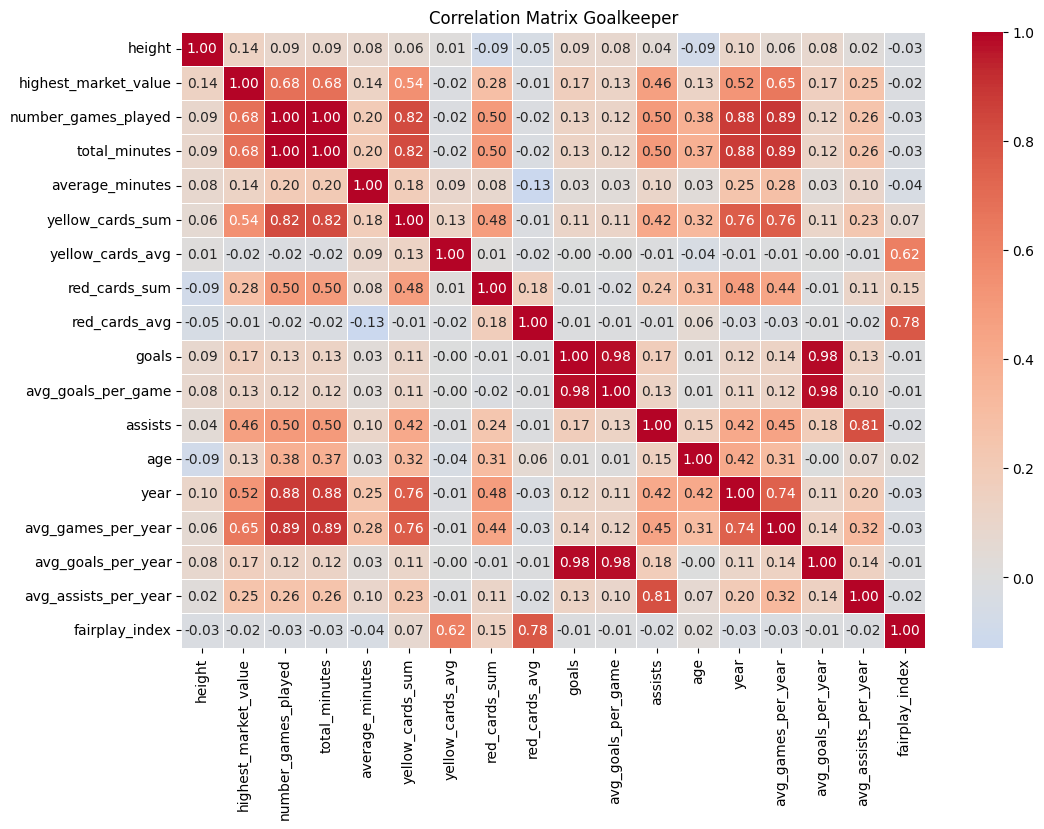

In [12]:
# Plot correlations for Defender
plot_correlation_matrix(df, 'Correlation Matrix Goalkeeper', 'Goalkeeper')

Looking at the correlation matrix for goalkeepers, we can see factors that are highly correlated with each other.

- The correlation between the **number of games played** and **total minutes played** is significant, with a correlation coefficient of 1, indicating a strong linear relationship. This suggests that players who have played in more matches tend to have more **total minutes** on the pitch. However, as the correlation is perfect (1), we decide to focus on the **total minutes played** variable alone for further analysis. This decision is based on the fact that goalkeepers who are rarely substituted may distort the correlation between the **number of games played** and **total minutes**.
- The **average minutes** does not have a significant correlation. It is considered as a factor.
- We also have a strong correlation between **goals** and **average goals**. The same goes for **assists**. We do not take these factors into account as goalkeepers very rarely score a goal and therefore this factor is not relevant to their market value.
- Due to the **fair play index** we disregard yellow and red cards.
- There is no significant correlation with **age**. 
- The year is strongly correlated with **average games played** and **total minutes played**. Therefore it is not taken into account.


Finally, we keep the following factors for the model: total minutes, **age**, **avg_games_per_year**, **fairplay_index**, **avg_minutes**.


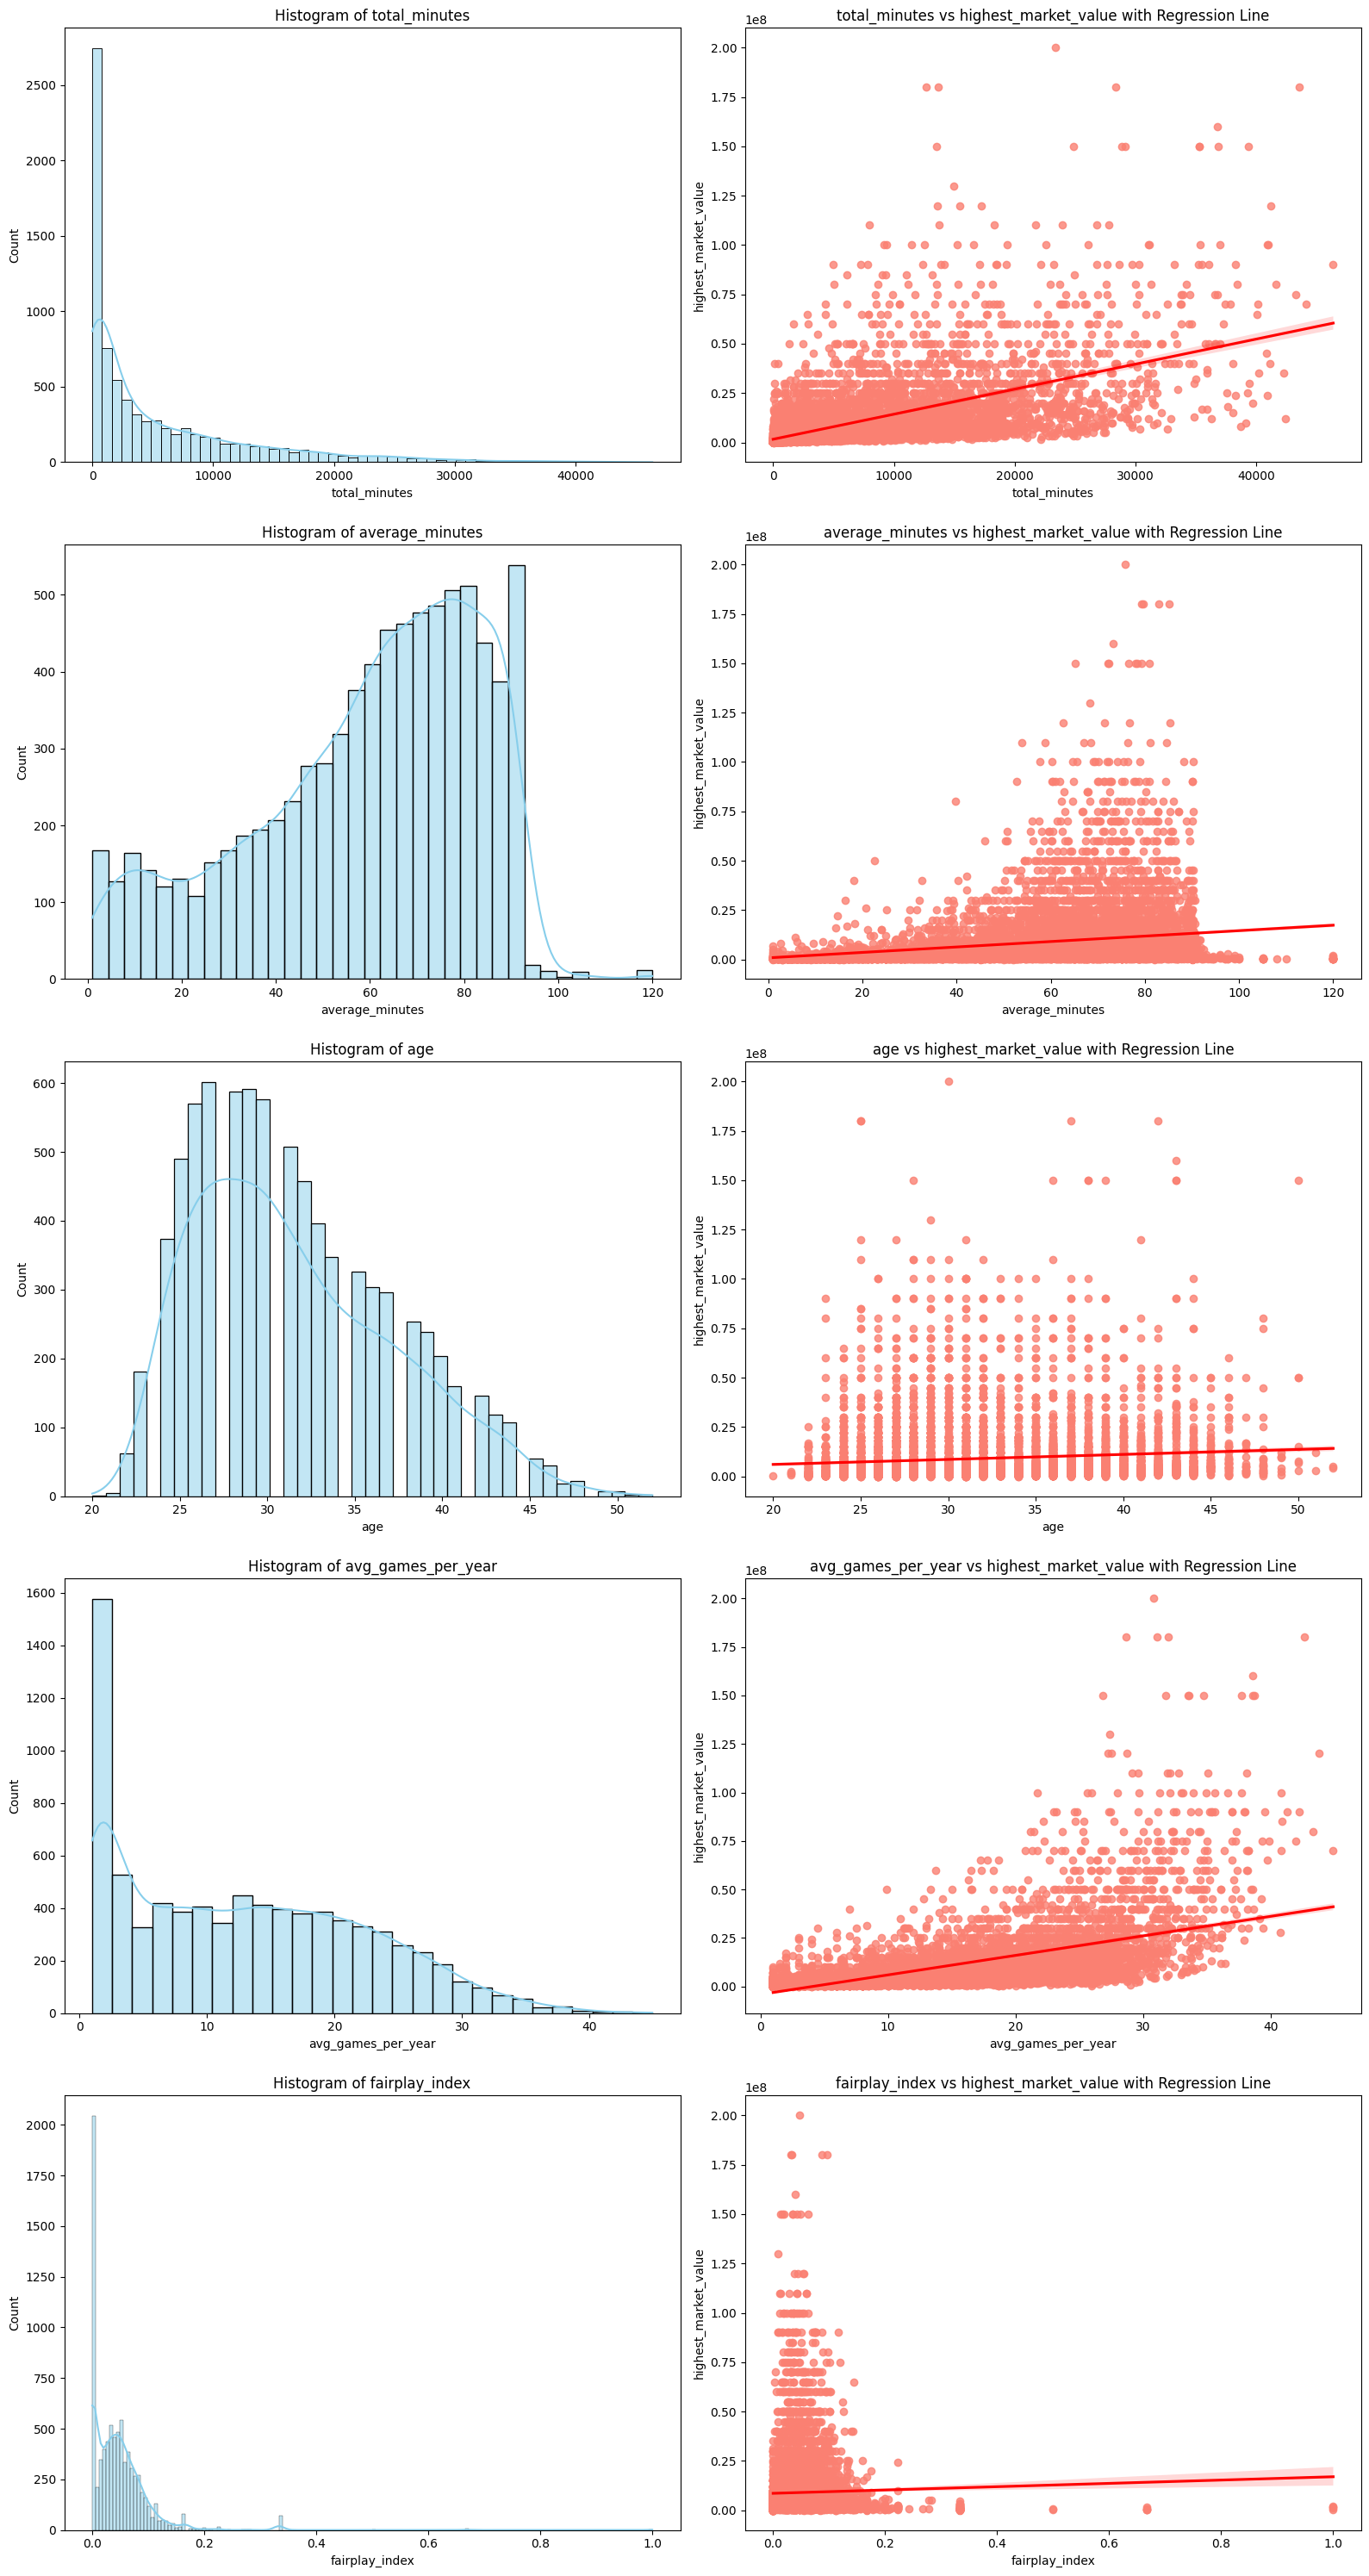

In [13]:
# List of performance features for Defender
features_goalkeeper = [
    'total_minutes',
    'average_minutes',
    'age',
    'avg_games_per_year',
    'fairplay_index'
]

# Plot insightful plots for Defender
plot_variable_distributions_with_regression(df, features_goalkeeper)

## Goalkeeper performance analysis

The graph we are going to look at is made up of histograms and scatter plots with regression lines relating different performance characteristics of players per position, in this case goalkeepers, to the market value of footballers. 

We will first analyse all the histograms, then the scatter plots and draw some conclusions about the correlations.

### Histogram analysis:

- **Total minutes played**: Right-skewed distribution, most players have no to a little time they spend playing.
- **Average minutes played**: We see two highs. First in the beginning and then we have a very high peak round 80 - 90 minutes.
- **Age**: Appears to be somewhat normally distributed, but with a slight right skew, indicating a larger number of younger players.
- **Average games per year**: We see a peak at the at the smallest values indicating that a lot of players play an ab^verage of very little games. Leaving that peak out it almost looks normal distributed.
- **Fairplay index**: Very high peak at 0 indicating that most players do not receive any yellow or red cards. Not really any distribution visible

### Scatter plots with regression line analysis:

- **Total minutes played vs. highest market value**: Positive trend, indicating that more minutes played does possibly influence a higher market value for goalkeepers.
- **Average minutes vs. highest market value**: Slightly positive trend, although the relationship appears weak due to a large concentration of data points at the lower end.
- **Age vs. highest market value**: Slightly positive trend, with a wide spread of data points indicating a weaker relationship between age and market value.
- **Average games per year vs. highest market value**: Positive trend, indicating a possible moderate correlation between playing on average more games in a year and higher market value.
- **Fairplay index per game vs. highest market value**: Slightly positive trend, although the relationship appears weak due to a large concentration of data points at the lower end.

### Correlation Conclusions:

**Higher correlation:**.
- **Total minutes played**: Strong positive trend, indicating a significant impact on a player's market value.

**Moderate correlation:**.
- **Average games per year** and **Average minutes played** show a positive trend, indicating a potential influence on market value.

**Low to negligible correlation:**.
- **Age** and **fairplay index** show weaker positive trends, suggesting that these variables may have a less significant impact on market value.


In [14]:
# Call the funtion to train and evaluate the df,specifying the desired position and selecting the features established before
goalkeeper_result = train_and_evaluate_models(df, 'Goalkeeper', features_goalkeeper)

# Print the results
print(f"Model evaluation results for Goalkeeper position:")

for model_name, metrics in goalkeeper_result.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Goalkeeper position:

LinearRegression:
  R^2 score: 0.5206
  Cross-Validation R^2 score: 0.4070
  Standard Deviation of CV R^2: 0.1356
  Intercept: 5752345.1327
  P-value: 0.8572
  F-value: 105.1972

RidgeRegression:
  R^2 score: 0.5207
  Cross-Validation R^2 score: 0.4077
  Standard Deviation of CV R^2: 0.1344
  Intercept: 5752345.1327
  P-value: 0.8572
  F-value: 105.1972

LassoRegression:
  R^2 score: 0.5206
  Cross-Validation R^2 score: 0.4070
  Standard Deviation of CV R^2: 0.1356
  Intercept: 5752345.1327
  P-value: 0.8572
  F-value: 105.1972

PolynomialRegression:
  R^2 score: 0.6177
  Cross-Validation R^2 score: 0.3971
  Standard Deviation of CV R^2: 0.2132

RandomForestRegressor:
  R^2 score: 0.7344
  Cross-Validation R^2 score: 0.4178
  Standard Deviation of CV R^2: 0.1829

GradientBoostingRegressor:
  R^2 score: 0.7160
  Cross-Validation R^2 score: 0.3642
  Standard Deviation of CV R^2: 0.1770

SVR:
  R^2 score: -0.1402
  Cross-Validation R^2 sc

### Goalkeeper Model evaluation

Observing the results, we are driven to conclude with the following statements:

- **RidgeRegression**, **LinearRegression** and **LassoRegression** perform well, but we have to note that **Linear Regression** and **Lasso Regression** have a slightly higher R^2 and Cross-Validation R^2 scores than the **Ridge Regression**. However, **Ridge Regression** has very close values. Therefore, we can say that the models perform almost the same for the position of the goalkeeper. 


## Defender

Before we start, let's plot our correlation matrix to see which characteristics may have a greater impact on predicting market value.

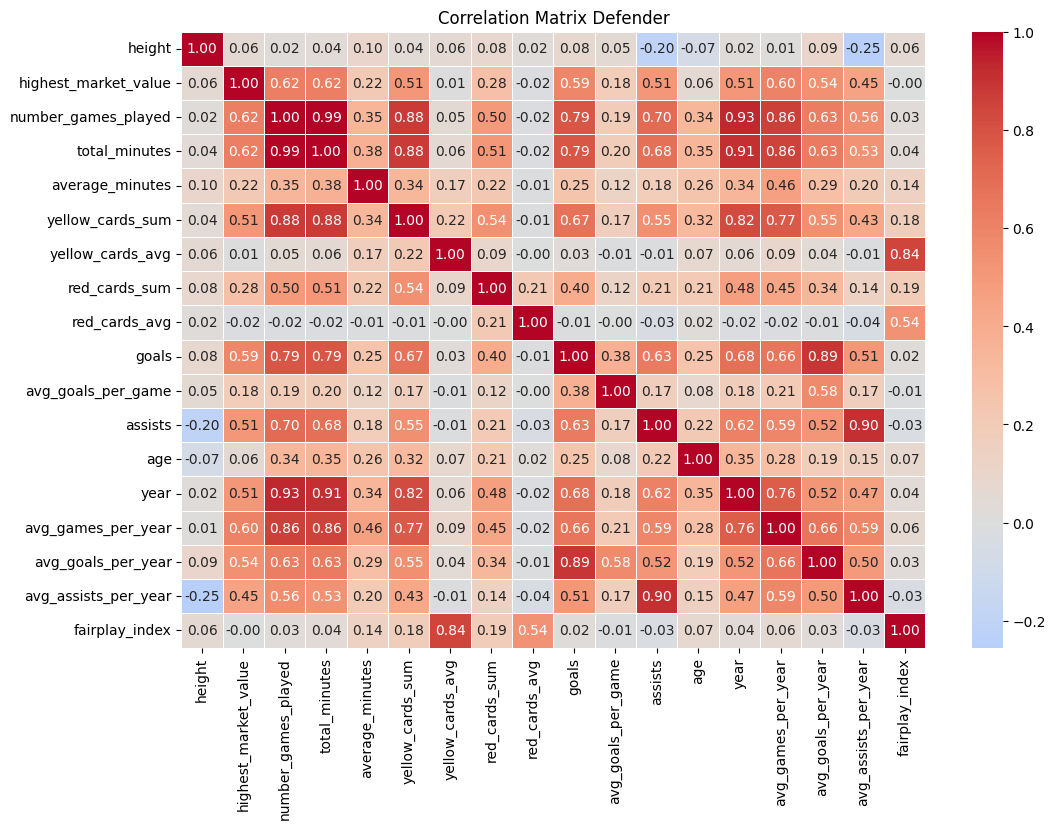

In [15]:
# Plot correlations for Defender
plot_correlation_matrix(df, 'Correlation Matrix Defender', 'Defender')

Looking at the correlation matrix for the defender position, we identified several characteristics with significant correlations to the market value:

- In the case of defenders, there is a strong positive correlation of 0.99 between the **number of games played** and **total minutes played**. This high correlation suggests that players who play in more games tend to accumulate more total minutes on the field. However, due to the almost perfect correlation between these two variables, we decide to include only the **total minutes played** variable in our analysis. This decision is made to avoid redundancy and to ensure the simplicity and effectiveness of the model.
Thus, while both the n**umber of games played** and the **total minutes played** provide insight into a player's activity, our focus remains solely on the total minutes played variable. 

    This decision is driven by its ability to provide a more accurate measure of a player's actual playing time and contribution on the pitch, regardless of the **number of games played**. In particular, the **total minutes played** variable retains its relevance, as demonstrated by the scenario where a player may appear in 38 matches in a season but only play 10 minutes per match, illustrating the nuanced nature of player involvement.

- **Average games per year**: Strong positive correlation, suggesting that players who play more games per year on average are valued higher.

- **Goals**: Strong positive correlation, suggesting that players who score more goals are likely to have higher market values.

- **Assists**: Also shows a good positive correlation, suggesting that players with more assists tend to have higher market values.

- **Average games per game**: This characteristic also shows a strong positive correlation, indicating that a higher average number of goals per game implies a higher market value.

- **Age**: Shows a strong negative correlation, indicating that younger players tend to have higher market values. This is a common trend in football, as younger players are perceived to have more potential and a longer career ahead of them.

- **Red Cards**: Typically, a high number of red cards would negatively correlate with a player's market value. Red cards often lead to suspensions and indicate disciplinary problems, which can reduce a player's value. However, the correlation in the matrix doesn't seem to be extremely strong. It may still be a factor, but its effect seems to be less significant compared to other features.

- **Yellow Cards**: Similarly to red cards, a higher number of yellow cards may indicate a disciplinary problem and potentially lead to suspensions once a certain threshold is reached. Although the correlation is weak, it suggests that it's a factor worth considering. However, like red cards, its impact seems to be less significant compared to other characteristics.

Given the similarities between goals and avg_goals_per_year, and assists and avg_assists_per_year, we will only consider one of each pair (the one with the higher correlation) for further analysis.


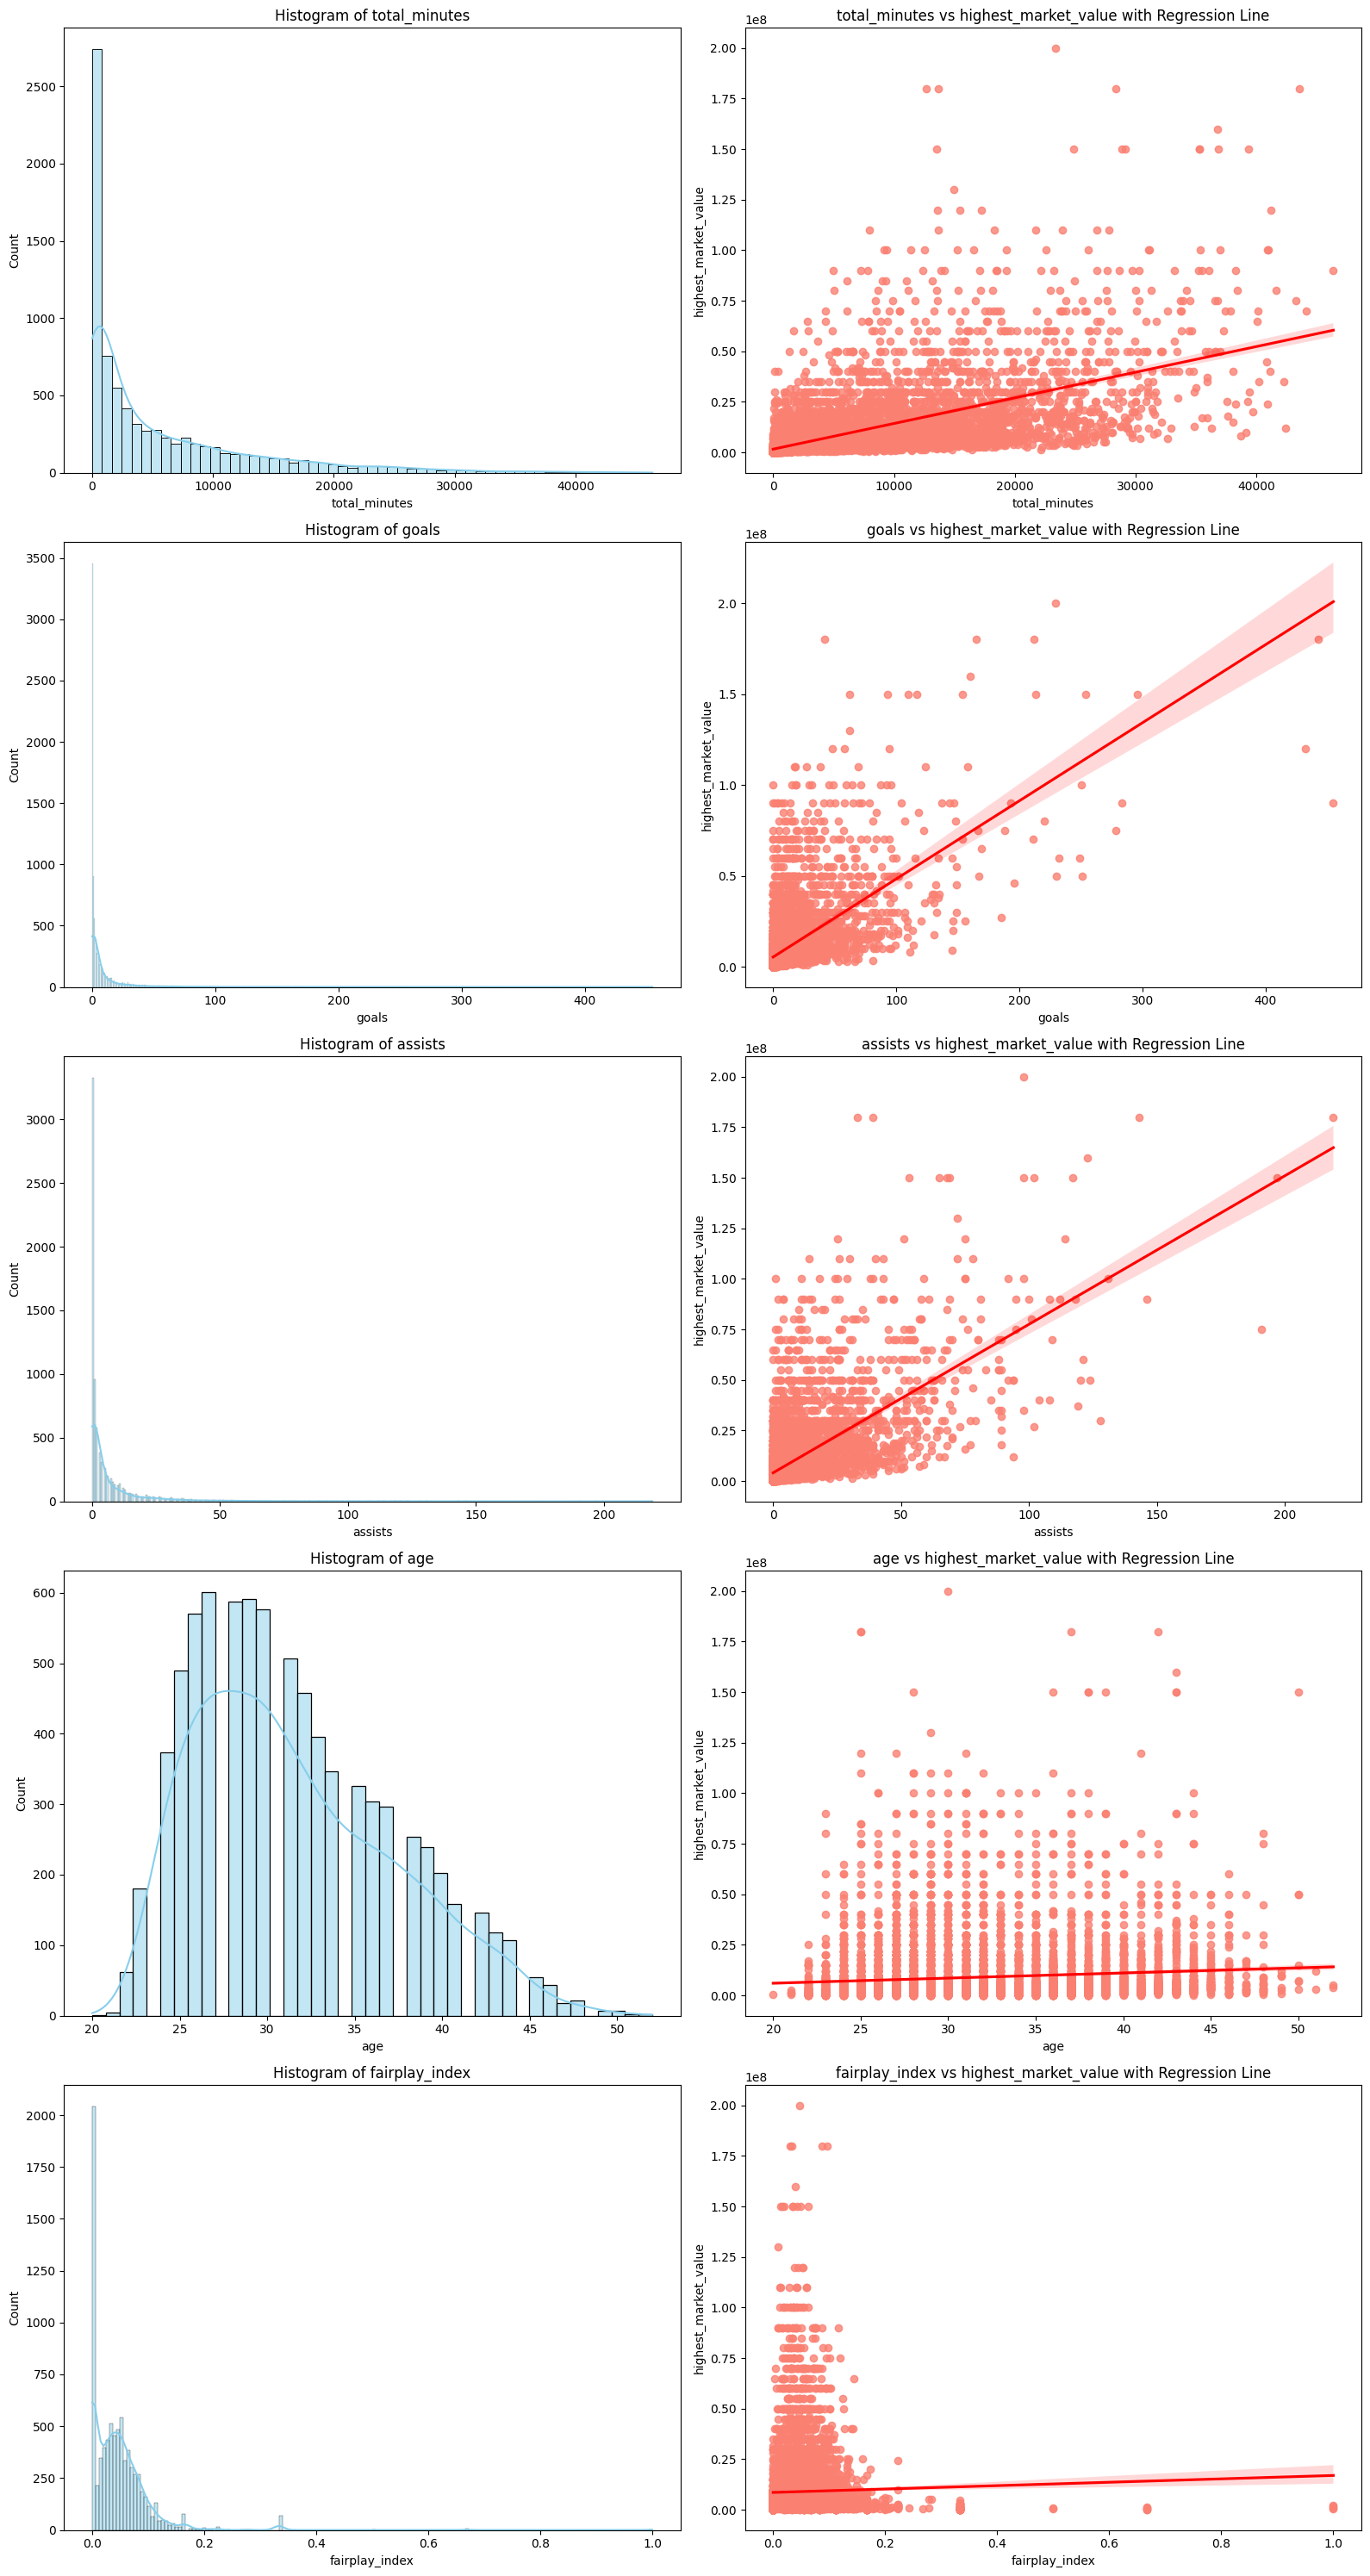

In [16]:
# List of performance features for Defender
features_defender = [
    'total_minutes',
    'goals',
    'assists',
    'age',
    'fairplay_index'
]

# Plot insightful plots for Defender
plot_variable_distributions_with_regression(df, features_defender)

## Defender performance analysis

The graph we are going to look at is made up of histograms and scatter plots with regression lines relating different performance characteristics of players per position, in this case defenders, to the market value of footballers. 

We will first analyse all the histograms, then the scatter plots and draw some conclusions about the correlations.

### Histogram analysis:
- **Goals**: Right-skewed distribution, most players have a low number of goals.
- **Assists**: Right-skewed distribution, most players have a low number of assists.
- **Total minutes played**: Right skewed, indicating that most players have fewer total minutes played.
- **Age**: Appears to be somewhat normally distributed, but with a slight right skew, indicating a larger number of younger players.
- **Fairplay index**: Very high peak at 0 indicating that most players do not receive any yellow or red cards. Not really any distribution visible

### Scatter plots with regression line analysis:

- **Goals vs. highest market value**: Positive trend with a concentration of data points at the lower end, suggesting that a higher number of goals may correlate with a higher market value.
- **Assists vs. highest market value**: Positive trend with a concentration of data points at the lower end, suggesting that a higher number of assists may correlate with a higher market value.
- **Total minutes played vs. highest market value**: Negative trend, indicating that more minutes played does not necessarily correlate with higher market value.
- **Age vs. Highest Market Value**: Positive trend, suggesting that up to a certain age there may be an increase in market value.
- **Fairplay index per game vs. highest market value**: Slightly positive trend, although the relationship appears weak due to a large concentration of data points at the lower end.

### Correlation Conclusions:

**Higher correlation:**.
- **Goals** and **Assists**: Strong positive trend, indicating a significant impact on a player's market value.

**Moderate correlation:**.
- **Total minutes played** and **goals** show a positive trend, indicating a potential influence on market value.

**Low to negligible correlation:**.
- **Age**, **yellow cards** and **red cards** show weaker positive trends, suggesting that these variables may have a less significant impact on market value.


In [17]:
# Call the funtion to train and evaluate the df,specifying the desired position and selecting the features established before
defender_results = train_and_evaluate_models(df, 'Defender', features_defender)

# Print the results
print(f"Model evaluation results for Defender position:")

for model_name, metrics in defender_results.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Defender position:

LinearRegression:
  R^2 score: 0.4238
  Cross-Validation R^2 score: 0.4136
  Standard Deviation of CV R^2: 0.0927
  Intercept: 7953575.2162
  P-value: 0.5482
  F-value: 337.7129

RidgeRegression:
  R^2 score: 0.4238
  Cross-Validation R^2 score: 0.4136
  Standard Deviation of CV R^2: 0.0926
  Intercept: 7953575.2162
  P-value: 0.5482
  F-value: 337.7129

LassoRegression:
  R^2 score: 0.4238
  Cross-Validation R^2 score: 0.4136
  Standard Deviation of CV R^2: 0.0927
  Intercept: 7953575.2162
  P-value: 0.5482
  F-value: 337.7129

PolynomialRegression:
  R^2 score: 0.4936
  Cross-Validation R^2 score: 0.4561
  Standard Deviation of CV R^2: 0.0825

RandomForestRegressor:
  R^2 score: 0.4396
  Cross-Validation R^2 score: 0.4175
  Standard Deviation of CV R^2: 0.0897

GradientBoostingRegressor:
  R^2 score: 0.4478
  Cross-Validation R^2 score: 0.4248
  Standard Deviation of CV R^2: 0.0816

SVR:
  R^2 score: -0.1412
  Cross-Validation R^2 scor

### Defender. Model evaluation

Observing the results, we are driven to conclude with the following statements:

- **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** perform well, but we have to note that **RidgeRegression** has the highest R^2 and Cross-Validation R^2 scores and is the most indicated for predicting market value. It is closely followed by **LinearRegression** and **LassoRegression**. **PolynomialRegression is also promising, but it's the worst of these four models.

- **RandomForestRegressor** and **GradientBoostingRegressor** have lower scores than the other four models, but still perform better than **SVR**, which has negative scores indicating poor performance.

Therefore, **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** are expected to give better predictions for the defender's position.


## Midfield

As we did with our last two positions, before we start we will plot our correlation matrix to see which features may have a greater impact on predicting our market value.

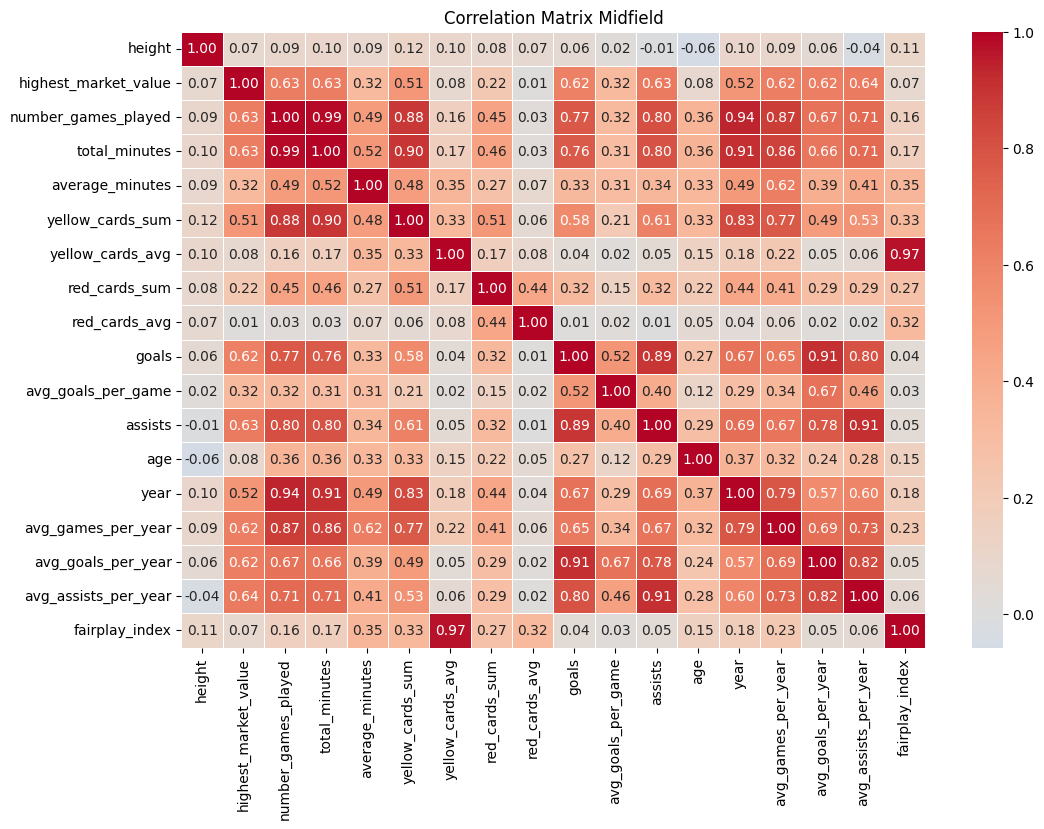

In [18]:
# Plot correlation matrix for Midfield
plot_correlation_matrix(df, 'Correlation Matrix Midfield', 'Midfield')

We see similar correlations to the defender analysis, so since defenders and midfielders can have similar roles on the pitch, we will continue with the same features.

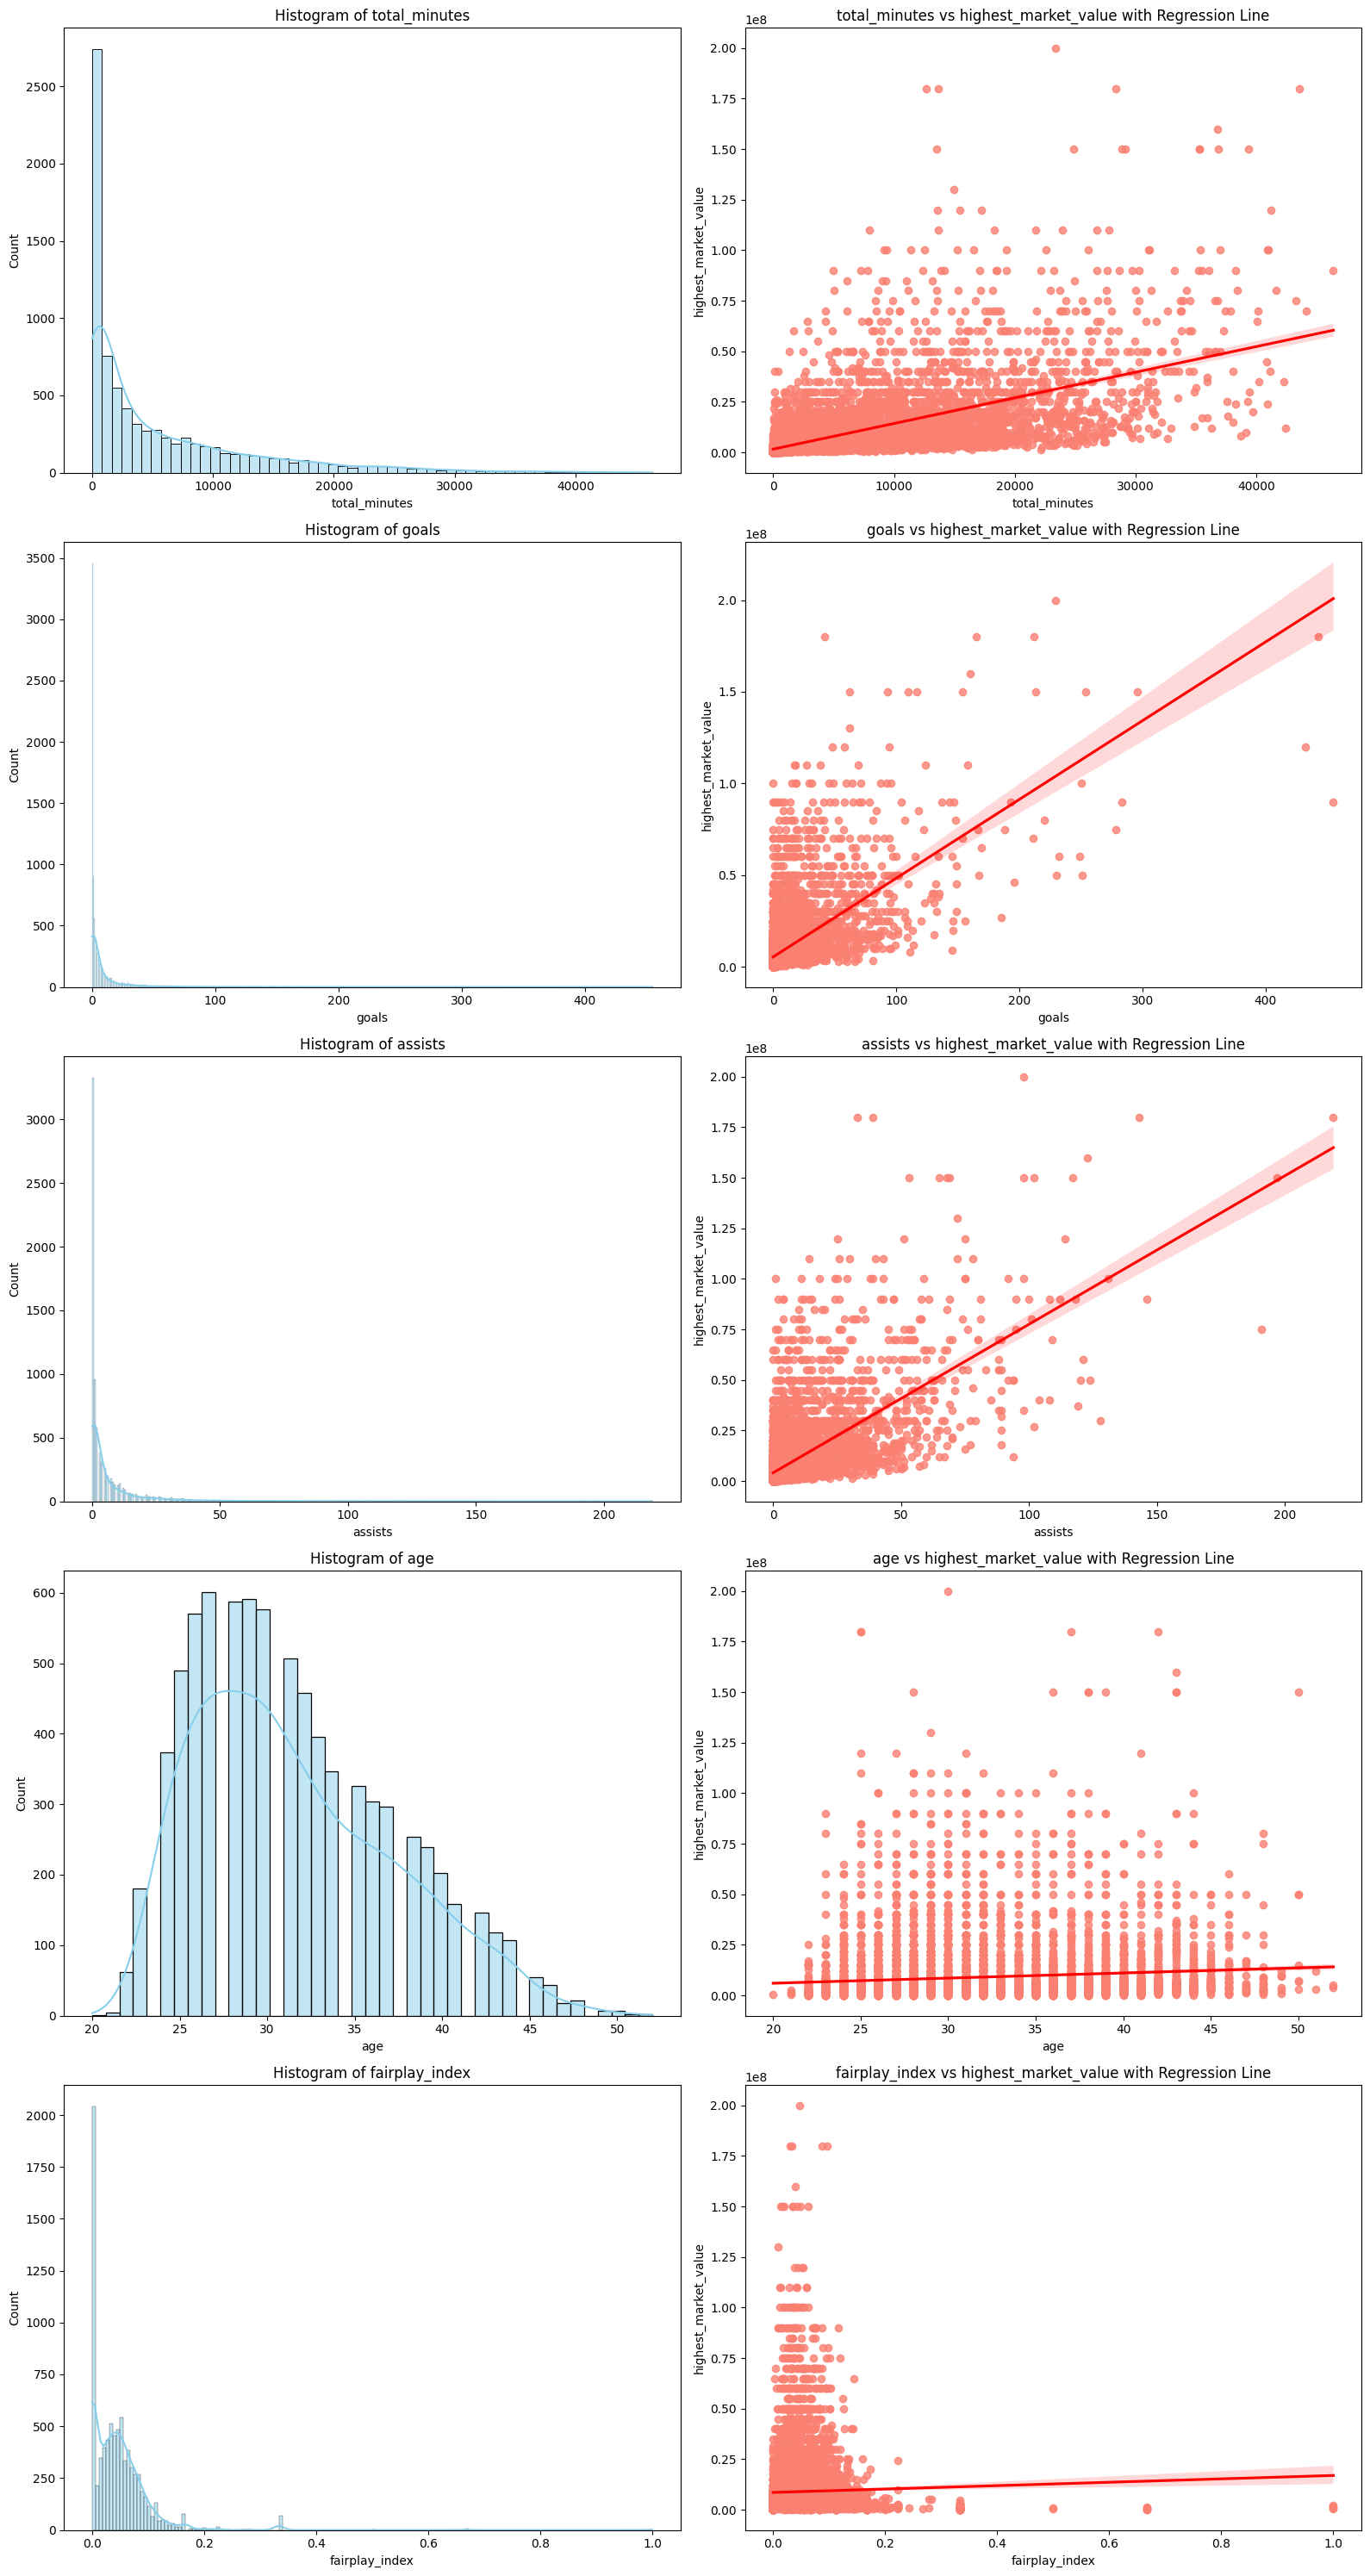

In [19]:
# List of performance features for Midfield
features_midfield = [
    'total_minutes',
    'goals',
    'assists',
    'age',
    'fairplay_index'
    
]

# Plot insightful plots for Midfield
plot_variable_distributions_with_regression(df, features_midfield)

## Midfield Performance Analysis

#### Plot Analysis:

- **Right Skewed Distributions**: Histograms show right-skewed distributions for key metrics such as **goals**, **assists**, **fair play index**, **total minutes played** and **age**.
- **Positive trends**: Scatter plots with regression lines indicate positive trends between critical metrics such as **goals**,**assists** and **total minutes played**.

#### Correlation conclusions:

- **Similar correlations**: The analysis of midfielders' performance mirrors that of defenders, showing comparable correlations between various performance metrics and disciplinary records and footballers' highest market value.
- **Weaker Correlations**: Some metrics such as **fair play index** show weaker correlations compared to others.
- **Strong correlations**: In particular, there's a **strong correlation** between **support** and **market value**.
- **Moderate Correlations**: Metrics such as **games played** and **average goals per game** show **moderate correlations** with market value.


In [20]:
midfield_results = train_and_evaluate_models(df, 'Midfield', features_midfield)

print(f"Model evaluation results for Midfield position:")

for model_name, metrics in midfield_results.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Midfield position:

LinearRegression:
  R^2 score: 0.5066
  Cross-Validation R^2 score: 0.4479
  Standard Deviation of CV R^2: 0.0370
  Intercept: 9460910.2640
  P-value: 0.2327
  F-value: 332.8946

RidgeRegression:
  R^2 score: 0.5066
  Cross-Validation R^2 score: 0.4479
  Standard Deviation of CV R^2: 0.0370
  Intercept: 9460910.2640
  P-value: 0.2327
  F-value: 332.8946

LassoRegression:
  R^2 score: 0.5066
  Cross-Validation R^2 score: 0.4479
  Standard Deviation of CV R^2: 0.0370
  Intercept: 9460910.2640
  P-value: 0.2327
  F-value: 332.8946

PolynomialRegression:
  R^2 score: 0.5376
  Cross-Validation R^2 score: 0.4831
  Standard Deviation of CV R^2: 0.0409

RandomForestRegressor:
  R^2 score: 0.4703
  Cross-Validation R^2 score: 0.4096
  Standard Deviation of CV R^2: 0.0712

GradientBoostingRegressor:
  R^2 score: 0.5274
  Cross-Validation R^2 score: 0.4368
  Standard Deviation of CV R^2: 0.0409

SVR:
  R^2 score: -0.1481
  Cross-Validation R^2 scor

### Midfield model evaluation

As expected, during the whole analysis we have compared it with the one done before for the defenders, etc., the values of the models for the midfield have a lot of similarities with the values of the models for the defenders, but still different, and in this case they are mostly a little bit bigger. Based on the results:

- **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** perform well, but we have to note that **RidgeRegression** has the highest R^2 and Cross-Validation R^2 values and is the most indicated for predicting the market value. It is closely followed by **LinearRegression** and **LassoRegression**. **PolynomialRegression is also promising, but it's the worst of these four models.
  
- **RandomForestRegressor** and **GradientBoostingRegressor** have lower scores than the other four models, but still perform better than **SVR**, which has negative scores indicating poor performance.

Therefore, **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** are expected to give better predictions for the defender's position.


## Striker

As the last position we will look at the market value analysis for strikers. 

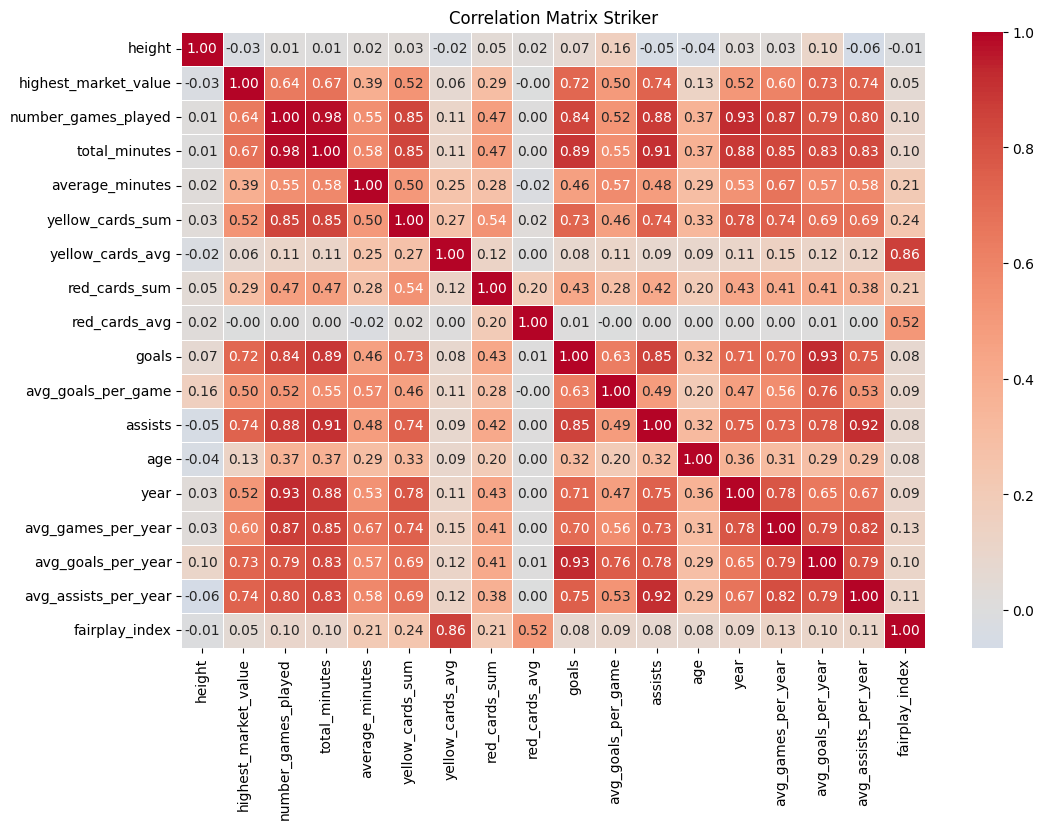

In [21]:
# Plot correlation matrix for Striker
plot_correlation_matrix(df, 'Correlation Matrix Striker', 'Attack')

Looking at the correlation matrix for the striker position, we identified several characteristics with significant correlations to the market value:

- **Total Minutes**: Strong positive correlation with number games played. Like with the other position the factor that interests us is the total minutes played therefore we will disregard the number of games played.


- **Average games per year**: Strong positive correlation with many factors such as assists and goals. Will keep factor in our modell.

- **Goals**: Strong positive correlation with average goals. We will disregard the total amount of goals and look at the average goals scored.

- **Assists**: Same as with goals.

- **Age**: No significant correlation with other factors.

- **Fairplay index**: No high correlation other to yellow cards indicating that for strikers often yellow cards are received. We will keep the fairplay index in the model.


Concluding for the model we keep the following factors: total_minutes, avg_minutes, year, avg_games_per_year, avg_goals_per_year, age, fairplay_index and avg_assist_per_year, year


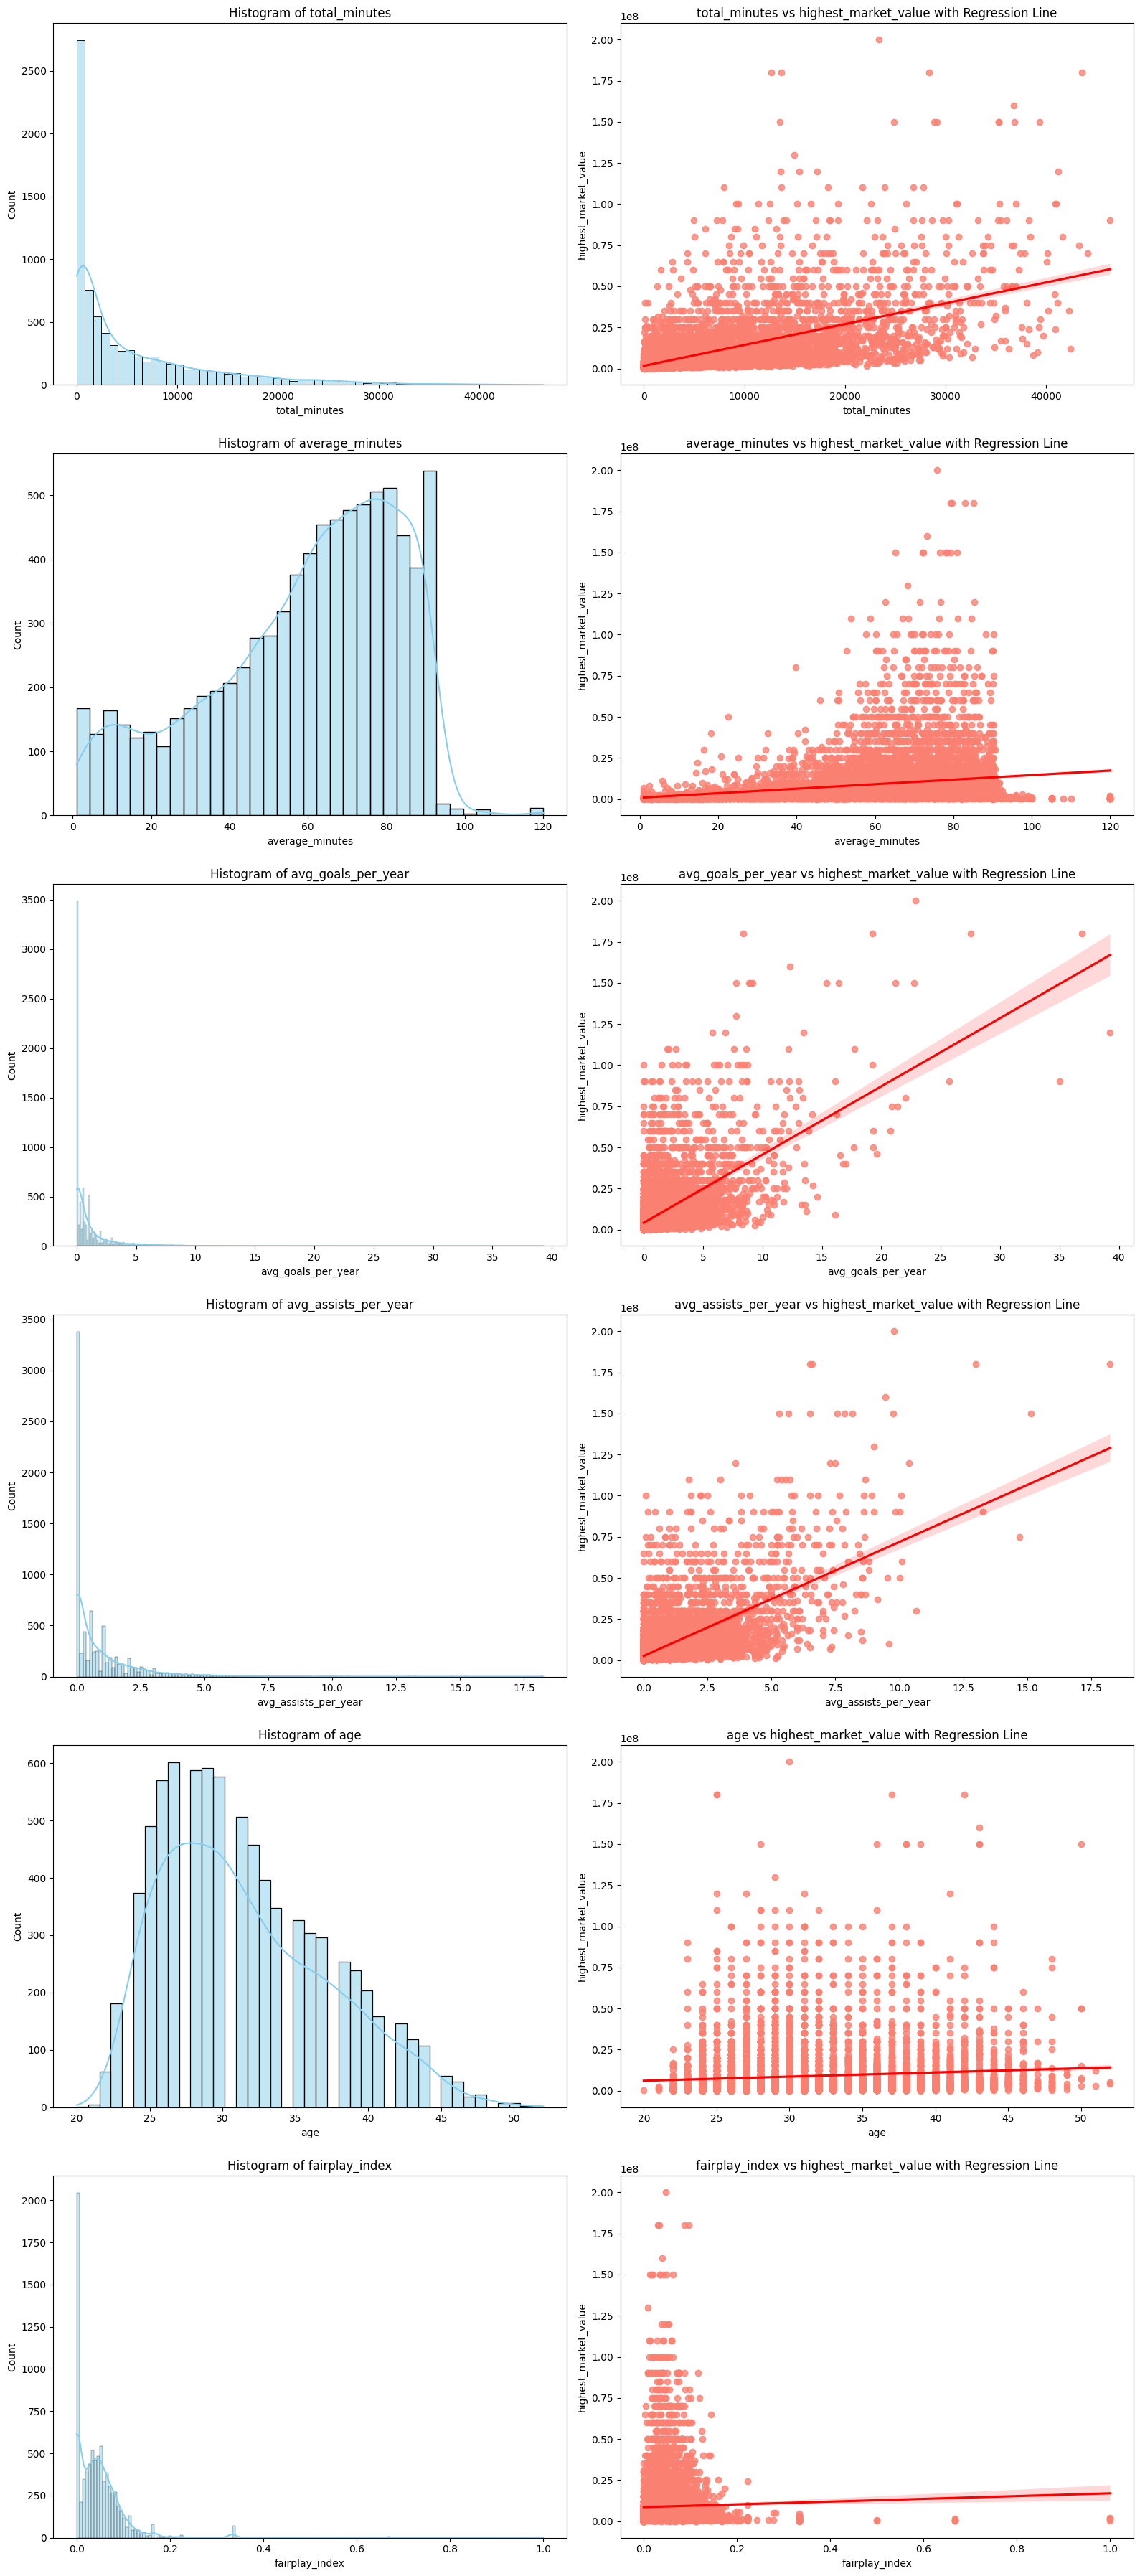

In [22]:
# List of performance features for Striker
features_striker = [
    'total_minutes',
    'average_minutes',
    'avg_goals_per_year',
    'avg_assists_per_year',
    'age',
    'fairplay_index',
]

# Plot insightful plots for Midfield
plot_variable_distributions_with_regression(df, features_striker)

## Striker performance analysis

The graph we are going to look at is made up of histograms and scatter plots with regression lines relating different performance characteristics of players per position, in this case strikers, to the market value of footballers. 

We will first analyse all the histograms, then the scatter plots and draw some conclusions about the correlations.

### Histogram analysis:

- **Total minutes played**: Right-skewed distribution, most players have no to a little time they spend playing.
- **Average minutes played**: We see two highs. First in the beginning and then we have a very high peak round 80 - 90 minutes.
- **Average goals per year**: Right-skewed distribution, most players score little to no goals on average in a year.
- **Average assists per year**: Right-skewed distribution, most players have no or few assists on average in a year.
- **Age**: Appears to be somewhat normally distributed, but with a slight right skew, indicating a larger number of younger players.
- **Fairplay index**: Right-skewed distribution with a peak at 0 indicating that strikers receive few yellow or red cards. If we compare to the goalkeepers from above we can see that they receive a higher amount.

### Scatter plots with regression line analysis:

- **Total minutes played vs. highest market value**: Positive trend, indicating that more minutes played does possibly influence a higher market value for goalkeepers.
- **Average minutes vs. highest market value**: Slightly positive trend, although the relationship appears weak due to a large concentration of data points at the lower end.
- **Average goals per year vs. highest market value**: Positive trend, indicating a  correlation between scoring on average a lot of goals in a year and higher market value.
- **Average assists per year vs. highest market value**: Positive trend, indicating a  correlation between assisting a lot on average in a year and higher market value.
- **Age vs. highest market value**: Slightly positive trend, with a wide spread of data points indicating a weaker relationship between age and market value.
- **Fairplay index per game vs. highest market value**: Slightly positive trend, although the relationship appears weak due to a large concentration of data points at the lower end.

### Correlation Conclusions:

**Higher correlation:**.
- **Average goals per year** and **average assists per year**: Strong positive trend, indicating a significant impact on a player's market value.

**Moderate correlation:**.
- **Average minutes played** and **total minutes played** show a positive trend, indicating a potential influence on market value.

**Low to negligible correlation:**.
- **Age** and **fairplay index** show weaker positive trends, suggesting that these variables may have a less significant impact on market value.


In [23]:
striker_result = train_and_evaluate_models(df, 'Attack', features_striker)

print(f"Model evaluation results for Midfield position:")

for model_name, metrics in striker_result.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Midfield position:

LinearRegression:
  R^2 score: 0.6223
  Cross-Validation R^2 score: 0.6029
  Standard Deviation of CV R^2: 0.0104
  Intercept: 10567483.4905
  P-value: 0.3273
  F-value: 479.3126

RidgeRegression:
  R^2 score: 0.6224
  Cross-Validation R^2 score: 0.6030
  Standard Deviation of CV R^2: 0.0105
  Intercept: 10567483.4905
  P-value: 0.3273
  F-value: 479.3126

LassoRegression:
  R^2 score: 0.6223
  Cross-Validation R^2 score: 0.6029
  Standard Deviation of CV R^2: 0.0104
  Intercept: 10567483.4905
  P-value: 0.3273
  F-value: 479.3126

PolynomialRegression:
  R^2 score: 0.4857
  Cross-Validation R^2 score: 0.5658
  Standard Deviation of CV R^2: 0.0772

RandomForestRegressor:
  R^2 score: 0.5726
  Cross-Validation R^2 score: 0.5857
  Standard Deviation of CV R^2: 0.0322

GradientBoostingRegressor:
  R^2 score: 0.5057
  Cross-Validation R^2 score: 0.5564
  Standard Deviation of CV R^2: 0.0608

SVR:
  R^2 score: -0.1474
  Cross-Validation R^2 s

### Striker Model evaluation

Observing the results, we are driven to conclude with the following statements:

- **RidgeRegression**, **LinearRegression** and **LassoRegression** perform well, but we have to note that **Ridge Regression** has a slightly higher R^2 and Cross-Validation R^2 scores. However, **Linear Regression** and **Lasso Regression** have very close values. Therefore, we can say that the models perform almost the same for the position of the goalkeeper. 


## Market value prediction for new players

### Example of predicting a new player with a defender position

In this section, we use the previously trained models to estimate market value. We'll give an overview of the estimated market values generated by each model.

However, at the end of our analysis, we'll make a final selection based on performance, specifically tailored to each player's position, in order to select the most accurate market value.

Predicted market value for new player using LinearRegression: 17759892161.275608
Predicted market value for new player using RidgeRegression: 17741249796.84989
Predicted market value for new player using LassoRegression: 17759888834.67663
Predicted market value for new player using PolynomialRegression: 7286423479783.383
Predicted market value for new player using RandomForestRegressor: 7913000.0
Predicted market value for new player using GradientBoostingRegressor: 11036091.812392555
Predicted market value for new player using SVR: 3499363.4340999685


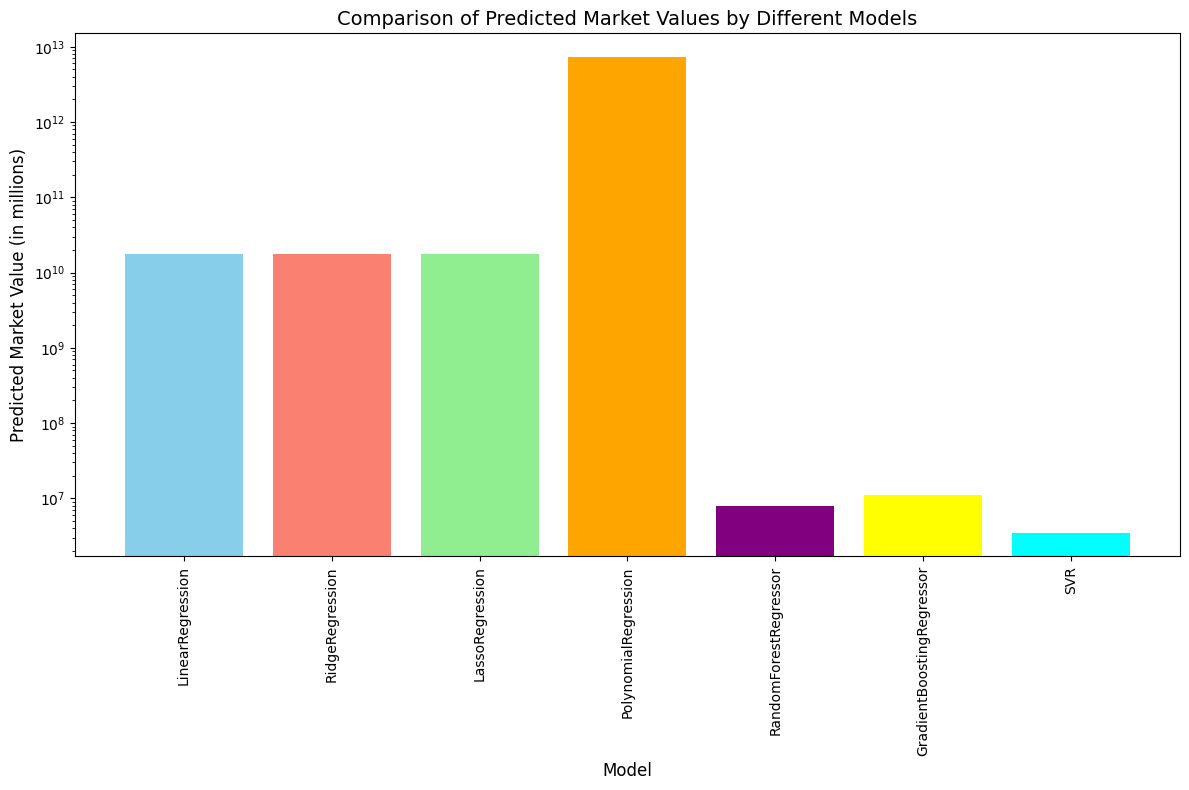

In [24]:
# Define the features of our players - Example for Defender
new_player_data = {
    'total_minutes': 3500,
    'goals': 3,
    'assists': 2,
    'age':24
    # Here we can add more features 
}

# Call the predict_market_value_for_new_player function with correct arguments
predictions = predict_market_value_for_new_player(defender_results['trained_models'], features_defender, new_player_data)

# Print predicted values for each model
for model_name, predicted_value in predictions.items():
    print(f"Predicted market value for new player using {model_name}: {predicted_value}")

# Filter out negative predictions for plotting
filtered_predictions = {model: value for model, value in predictions.items() if value >= 0}

# Plot the predictions with logarithmic scale
plt.figure(figsize=(12, 8))

model_names = list(filtered_predictions.keys())
predicted_values = list(filtered_predictions.values())
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'yellow', 'cyan']

plt.bar(model_names, predicted_values, color=colors)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Predicted Market Value (in millions)', fontsize=12)
plt.title('Comparison of Predicted Market Values by Different Models', fontsize=14)
plt.xticks(rotation=90)
plt.yscale('log') 
plt.tight_layout()
plt.show()


Based on the predictions and model valuation results:

- **LinearRegression**, **RidgeRegression** and **LassoRegression** all predict very high market values for the new player features introduced. We affirm that these predictions are consistent with their relatively high R^2 scores and cross-validation R^2 scores, which fully explain the variance in the data. However, it's important to note that these models may be overfitting of the data due to predicted values being too high.

- The **PolynomialRegression** predicts a really big market value, so we take the decision of not to include the Polynomial Regression model because its predictions are disproportionately high compared to other models, which could potentially distort the analysis or lead to misleading conclusions about market values.

- The **RandomForestRegressor** and **GradientBoostingRegressor** predict much lower market values than the linear models, in the millions. This is consistent with their lower R^2 scores and cross-validation R^2 scores, indicating less predictive power than the linear models.

- **SVR** predicts the lowest market value of all the models, which is consistent with its negative R^2 score and Cross-Validation R^2 score, indicating poor performance in explaining the variance in the data.

In summary, based on the predictions and model evaluation results, the linear models (**LinearRegression**, **RidgeRegression** and **LassoRegression**) appear to predict higher market values for the new player compared to other models. However, given the excessively high predicted values, it may be necessary to further investigate the performance of the models and maybe look for a better fit.

## Conclusion
Summarising the results of this analysis, it is clear that there are discernible patterns in the composition of market value for different positions in football.

### Goalkeepers
- For goalkeepers, total minutes played appears to be the key determinant of market value. Notably, the linear, ridge and lasso regression models all showed commendable performance in accurately predicting the market value of goalkeepers, underlining the reliability of these methods in this context.

### Defenders
- For defenders, correlations between market value and key metrics such as minutes played, goals and assists emerged. In particular, the linear, ridge and lasso regression models showed remarkable effectiveness in predicting the market value of defenders, reflecting the robustness of these analytical approaches.

### Midfielders
- Midfielders showed correlations between market value and performance metrics such as goals, assists and average minutes played. Once again, the linear, ridge and lasso regression models proved to be reliable tools for predicting the market value of midfielders, demonstrating their versatility across different player positions.

### Strikers
- The analysis of strikers highlighted the importance of metrics such as average goals per year and average assists per year in determining market value. Encouragingly, the linear, ridge and lasso regression models consistently provided accurate predictions for the market value of strikers, confirming their effectiveness in this area.


This analysis shows how complex it is to figure out how much a football player is worth. Different things like where they play on the field and how well they perform all play a big role. By using strong regression models that fit each position, people involved can make better guesses about a player's value. This helps them decide which players to pick and make smarter decisions overall. Taking this big-picture approach not only helps with evaluating talent but also gives important information for picking players and building teams better.